In [3]:
from __future__ import division
import os
from os.path import join
import numpy as np
import pandas as pd

%pylab inline

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [4]:
# paths to subject dir
subj = '13034'
dataDir = '../data'

# Classification 
Classification analyses on one subject. This notebook walks through the steps for prepping the data, and setting up a classification.

This experiment was a single run task with 48 trials. On each trial, subjects were presented with a stimulus in the form of either a **Word** or a **Picture** (24 stims from each modality).

Stimuli represented either **Dwellings** or **Tools** (equally balanced across modalities). 

There were 8 unique stimuli. 

** Stimuli Breakdown:**

* 24 Words
    * 12 Dwellings
        * 4 stims (as words), repeated 3x each
    * 12 Tools 
        * 4 stims (as words), repeated 3x each
* 24 Pics
    * 12 Dwellings
        * 4 stims (as pics), repeated 3x each
    * 12 Tools
        * 4 stims (as pics), repeated 3x each


The analyses will focus on classifying between different combinations of these stimuli representations (e.g. classifying between words and pics)

# Preprocessing

---
## Prepare the attributes
Prepare a set of volume labels that can be used to slice the dataset up for different analyses.  

In [5]:
# read trialOnsets file
trialOnsets = pd.read_table(join(dataDir, subj, (subj + '_trialOnsets.txt')))
trialOnsets.head()

,TrialOnset,Modality,Category,Stimulus
0,2000,Word,dwelling,castle
1,11995,Word,tool,saw
2,22007,Word,dwelling,house
3,32002,Word,dwelling,tent
4,41980,Word,tool,screwdriver


In [6]:
# drop the trial onset times, as we don't need that
trials = trialOnsets.drop('TrialOnset', axis=1)
trials.shape

(48, 3)

### Make additional columns for category by word/pic and stim by word/pic

In [7]:
def catByWord(row):
    if row['Modality'] == 'Word':
        label = row['Category'] + 'Word'
    else:
        label = 'n'
    return label

def catByPic(row):
    if row['Modality'] == 'Picture':
        label = row['Category'] + 'Pic'
    else:
        label = 'n'
    return label

def stimByWord(row):
    if row['Modality'] == 'Word':
        label = row['Stimulus'] + 'Word'
    else:
        label = 'n'
    return label

def stimByPic(row):
    if row['Modality'] == 'Picture':
        label = row['Stimulus'] + 'Pic'
    else:
        label = 'n'
    return label

In [8]:
trials['categoryWords'] = trials.apply(catByWord, axis=1)
trials['categoryPics'] = trials.apply(catByPic, axis=1)
trials['stimulusWords'] = trials.apply(stimByWord, axis=1)
trials['stimulusPics'] = trials.apply(stimByPic, axis=1)

Here is the table that contains all of our sample labels

In [9]:
trials.head()

,Modality,Category,Stimulus,categoryWords,categoryPics,stimulusWords,stimulusPics
0,Word,dwelling,castle,dwellingWord,n,castleWord,n
1,Word,tool,saw,toolWord,n,sawWord,n
2,Word,dwelling,house,dwellingWord,n,houseWord,n
3,Word,dwelling,tent,dwellingWord,n,tentWord,n
4,Word,tool,screwdriver,toolWord,n,screwdriverWord,n


In [164]:
trials.columns

Index(['Modality', 'Category', 'Stimulus', 'categoryWords', 'categoryPics',
       'stimulusWords', 'stimulusPics'],
      dtype='object')

## Load the subject's brain data

For this analysis, the functional data has been preprocessed with the following steps:

* motion correction
* non-brain removal with BET (along with func mask creation)
* 4mm smoothing
* highpass filtered (Gaussian least-squares straight-line fitting, sigma=40.0s)

In addition, we ran first level GLMs to extract SPMs that represented single trial parameter estimates. For each trial, a model was fit with two regressors: 1) convolved regressor representing THAT trial, and 2) convolved regressor representing ALL OTHER trials. The unique parameter estimate map for each trial was extracted and merged across time to produce a 4D file. There are 48 'timepts' in this 4D file, each representing the whole brain parameter estimate map for a single trial

The 4D single-trial parameter maps will be used as the input dataset for our classification

In [10]:
# import tools to read nifti data
import nilearn as nl
import nibabel as nib

In [11]:
subj_dataDir = join(dataDir, subj)
bold_file = join(subj_dataDir, 'singleTrialGLM/singleTrialPEs.nii.gz')
mask_file = join(subj_dataDir, 'masks/TDSL2_brain_mask.nii.gz')

In [12]:
# create a Nilearn Masker...this will convert the dataset to a 2D array
# as well as standardize the voxel timeseries
from nilearn.input_data import NiftiMasker

In [13]:
masker = NiftiMasker(mask_img=mask_file, standardize=True)
fmri_masked = masker.fit_transform(bold_file)
fmri_masked.shape

(48, 25182)

In [198]:
from nilearn.image import index_img

In [200]:
samplesMask = trials['Modality'] == 'Word'
fmri_img = index_img(bold_file, samplesMask)
type(fmri_img)

nibabel.nifti1.Nifti1Image

In [202]:
type(mask)

NameError: name 'mask' is not defined

In [201]:
fmri_img.shape

(80, 80, 17, 24)

# Start Classifying

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

### Start simple - whole brain SVM on Words vs Pics
See how well an SVM can discrimate between WORD trials and PIC trials using the entire brain volume as input

In [38]:
# load decoder
from sklearn.svm import SVC

In [58]:
# test how well stratified K-fold does the trick
skf = StratifiedKFold(n_splits=5, random_state=1)

In [62]:
model = SVC(kernel='linear')
X = fmri_masked
y = trials['Modality']

# run leave one out cross validation on this model
cv_scores = cross_val_score(model, X, y, cv=skf, n_jobs=4)
print(cv_scores.mean())

0.62


## Searchlight approach

In [139]:
from nilearn.decoding import SearchLight

In [184]:
# retrieve the mask numpy array from the Masker
mask_img = nl.image.load_img(mask_file)
fmri = nl.image.load_img(bold_file)

searchlight = SearchLight(
            mask_img,
            radius=5,
            n_jobs=-1,
            verbose=1,
            cv=skf)

searchlight.fit(fmri, trials['Modality'])

Job #1, processed 0/3148 voxels (0.00%, 295 seconds remaining)
Job #2, processed 0/3148 voxels (0.00%, 415 seconds remaining)
Job #3, processed 0/3148 voxels (0.00%, 605 seconds remaining)
Job #1, processed 10/3148 voxels (0.32%, 89 seconds remaining)
Job #2, processed 10/3148 voxels (0.32%, 113 seconds remaining)
Job #4, processed 0/3148 voxels (0.00%, 560 seconds remaining)
Job #3, processed 10/3148 voxels (0.32%, 143 seconds remaining)
Job #5, processed 0/3148 voxels (0.00%, 626 seconds remaining)
Job #1, processed 20/3148 voxels (0.64%, 85 seconds remaining)
Job #6, processed 0/3148 voxels (0.00%, 764 seconds remaining)
Job #7, processed 0/3147 voxels (0.00%, 891 seconds remaining)
Job #8, processed 0/3147 voxels (0.00%, 1237 seconds remaining)
Job #2, processed 20/3148 voxels (0.64%, 143 seconds remaining)
Job #1, processed 30/3148 voxels (0.95%, 107 seconds remaining)
Job #4, processed 10/3148 voxels (0.32%, 217 seconds remaining)
Job #7, processed 10/3147 voxels (0.32%, 166 seco

Job #2, processed 160/3148 voxels (5.08%, 159 seconds remaining)
Job #6, processed 150/3148 voxels (4.76%, 161 seconds remaining)
Job #1, processed 200/3148 voxels (6.35%, 129 seconds remaining)
Job #5, processed 140/3148 voxels (4.45%, 180 seconds remaining)
Job #8, processed 140/3147 voxels (4.45%, 177 seconds remaining)
Job #7, processed 180/3147 voxels (5.72%, 137 seconds remaining)
Job #6, processed 160/3148 voxels (5.08%, 158 seconds remaining)
Job #4, processed 160/3148 voxels (5.08%, 161 seconds remaining)
Job #3, processed 150/3148 voxels (4.76%, 180 seconds remaining)
Job #2, processed 170/3148 voxels (5.40%, 159 seconds remaining)
Job #1, processed 210/3148 voxels (6.67%, 128 seconds remaining)
Job #6, processed 170/3148 voxels (5.40%, 155 seconds remaining)
Job #8, processed 150/3147 voxels (4.77%, 176 seconds remaining)
Job #7, processed 190/3147 voxels (6.04%, 138 seconds remaining)
Job #5, processed 150/3148 voxels (4.76%, 180 seconds remaining)
Job #4, processed 170/314

Job #4, processed 310/3148 voxels (9.85%, 147 seconds remaining)
Job #3, processed 320/3148 voxels (10.17%, 145 seconds remaining)
Job #8, processed 290/3147 voxels (9.22%, 156 seconds remaining)
Job #5, processed 290/3148 voxels (9.21%, 160 seconds remaining)
Job #1, processed 360/3148 voxels (11.44%, 129 seconds remaining)
Job #7, processed 320/3147 voxels (10.17%, 144 seconds remaining)
Job #3, processed 330/3148 voxels (10.48%, 144 seconds remaining)
Job #6, processed 340/3148 voxels (10.80%, 136 seconds remaining)
Job #8, processed 300/3147 voxels (9.53%, 155 seconds remaining)
Job #4, processed 320/3148 voxels (10.17%, 147 seconds remaining)
Job #2, processed 310/3148 voxels (9.85%, 156 seconds remaining)
Job #1, processed 370/3148 voxels (11.75%, 129 seconds remaining)
Job #5, processed 300/3148 voxels (9.53%, 160 seconds remaining)
Job #3, processed 340/3148 voxels (10.80%, 143 seconds remaining)
Job #7, processed 330/3147 voxels (10.49%, 144 seconds remaining)
Job #4, processe

Job #2, processed 450/3148 voxels (14.29%, 147 seconds remaining)
Job #6, processed 470/3148 voxels (14.93%, 137 seconds remaining)
Job #4, processed 490/3148 voxels (15.57%, 131 seconds remaining)
Job #7, processed 470/3147 voxels (14.93%, 137 seconds remaining)
Job #1, processed 520/3148 voxels (16.52%, 125 seconds remaining)
Job #8, processed 440/3147 voxels (13.98%, 149 seconds remaining)
Job #3, processed 510/3148 voxels (16.20%, 128 seconds remaining)
Job #5, processed 440/3148 voxels (13.98%, 151 seconds remaining)
Job #2, processed 460/3148 voxels (14.61%, 146 seconds remaining)
Job #4, processed 500/3148 voxels (15.88%, 130 seconds remaining)
Job #6, processed 480/3148 voxels (15.25%, 136 seconds remaining)
Job #7, processed 480/3147 voxels (15.25%, 136 seconds remaining)
Job #1, processed 530/3148 voxels (16.84%, 125 seconds remaining)
Job #3, processed 520/3148 voxels (16.52%, 128 seconds remaining)
Job #8, processed 450/3147 voxels (14.30%, 148 seconds remaining)
Job #4, pr

Job #2, processed 590/3148 voxels (18.74%, 145 seconds remaining)
Job #7, processed 650/3147 voxels (20.65%, 127 seconds remaining)
Job #8, processed 580/3147 voxels (18.43%, 146 seconds remaining)
Job #4, processed 650/3148 voxels (20.65%, 128 seconds remaining)
Job #1, processed 680/3148 voxels (21.60%, 122 seconds remaining)
Job #3, processed 680/3148 voxels (21.60%, 123 seconds remaining)
Job #5, processed 580/3148 voxels (18.42%, 148 seconds remaining)
Job #6, processed 630/3148 voxels (20.01%, 134 seconds remaining)
Job #2, processed 600/3148 voxels (19.06%, 144 seconds remaining)
Job #7, processed 660/3147 voxels (20.97%, 126 seconds remaining)
Job #1, processed 690/3148 voxels (21.92%, 122 seconds remaining)
Job #8, processed 590/3147 voxels (18.75%, 146 seconds remaining)
Job #4, processed 660/3148 voxels (20.97%, 128 seconds remaining)
Job #3, processed 690/3148 voxels (21.92%, 122 seconds remaining)
Job #2, processed 610/3148 voxels (19.38%, 143 seconds remaining)
Job #7, pr

Job #8, processed 720/3147 voxels (22.88%, 140 seconds remaining)
Job #6, processed 790/3148 voxels (25.10%, 125 seconds remaining)
Job #2, processed 760/3148 voxels (24.14%, 134 seconds remaining)
Job #3, processed 820/3148 voxels (26.05%, 121 seconds remaining)
Job #5, processed 720/3148 voxels (22.87%, 143 seconds remaining)
Job #4, processed 800/3148 voxels (25.41%, 124 seconds remaining)
Job #7, processed 840/3147 voxels (26.69%, 116 seconds remaining)
Job #1, processed 840/3148 voxels (26.68%, 118 seconds remaining)
Job #8, processed 730/3147 voxels (23.20%, 140 seconds remaining)
Job #6, processed 800/3148 voxels (25.41%, 125 seconds remaining)
Job #2, processed 770/3148 voxels (24.46%, 133 seconds remaining)
Job #5, processed 730/3148 voxels (23.19%, 142 seconds remaining)
Job #4, processed 810/3148 voxels (25.73%, 124 seconds remaining)
Job #3, processed 830/3148 voxels (26.37%, 121 seconds remaining)
Job #1, processed 850/3148 voxels (27.00%, 117 seconds remaining)
Job #7, pr

Job #2, processed 900/3148 voxels (28.59%, 127 seconds remaining)
Job #3, processed 970/3148 voxels (30.81%, 114 seconds remaining)
Job #4, processed 950/3148 voxels (30.18%, 117 seconds remaining)
Job #6, processed 980/3148 voxels (31.13%, 112 seconds remaining)
Job #5, processed 860/3148 voxels (27.32%, 135 seconds remaining)
Job #1, processed 1000/3148 voxels (31.77%, 110 seconds remaining)
Job #7, processed 990/3147 voxels (31.46%, 111 seconds remaining)
Job #8, processed 890/3147 voxels (28.28%, 129 seconds remaining)
Job #6, processed 990/3148 voxels (31.45%, 111 seconds remaining)
Job #3, processed 980/3148 voxels (31.13%, 114 seconds remaining)
Job #4, processed 960/3148 voxels (30.50%, 117 seconds remaining)
Job #2, processed 910/3148 voxels (28.91%, 127 seconds remaining)
Job #1, processed 1010/3148 voxels (32.08%, 110 seconds remaining)
Job #5, processed 870/3148 voxels (27.64%, 135 seconds remaining)
Job #6, processed 1000/3148 voxels (31.77%, 110 seconds remaining)
Job #3,

Job #8, processed 1020/3147 voxels (32.41%, 122 seconds remaining)
Job #6, processed 1140/3148 voxels (36.21%, 103 seconds remaining)
Job #7, processed 1140/3147 voxels (36.22%, 103 seconds remaining)
Job #5, processed 1000/3148 voxels (31.77%, 127 seconds remaining)
Job #3, processed 1160/3148 voxels (36.85%, 102 seconds remaining)
Job #4, processed 1100/3148 voxels (34.94%, 110 seconds remaining)
Job #1, processed 1150/3148 voxels (36.53%, 104 seconds remaining)
Job #2, processed 1060/3148 voxels (33.67%, 118 seconds remaining)
Job #7, processed 1150/3147 voxels (36.54%, 103 seconds remaining)
Job #6, processed 1150/3148 voxels (36.53%, 103 seconds remaining)
Job #8, processed 1030/3147 voxels (32.73%, 122 seconds remaining)
Job #3, processed 1170/3148 voxels (37.17%, 101 seconds remaining)
Job #5, processed 1010/3148 voxels (32.08%, 126 seconds remaining)
Job #4, processed 1110/3148 voxels (35.26%, 110 seconds remaining)
Job #7, processed 1160/3147 voxels (36.86%, 102 seconds remain

Job #6, processed 1280/3148 voxels (40.66%, 98 seconds remaining)
Job #4, processed 1270/3148 voxels (40.34%, 100 seconds remaining)
Job #5, processed 1150/3148 voxels (36.53%, 117 seconds remaining)
Job #2, processed 1190/3148 voxels (37.80%, 112 seconds remaining)
Job #8, processed 1160/3147 voxels (36.86%, 115 seconds remaining)
Job #7, processed 1310/3147 voxels (41.63%, 94 seconds remaining)
Job #3, processed 1350/3148 voxels (42.88%, 90 seconds remaining)
Job #1, processed 1290/3148 voxels (40.98%, 98 seconds remaining)
Job #6, processed 1290/3148 voxels (40.98%, 97 seconds remaining)
Job #5, processed 1160/3148 voxels (36.85%, 116 seconds remaining)
Job #4, processed 1280/3148 voxels (40.66%, 99 seconds remaining)
Job #7, processed 1320/3147 voxels (41.94%, 94 seconds remaining)
Job #3, processed 1360/3148 voxels (43.20%, 90 seconds remaining)
Job #2, processed 1200/3148 voxels (38.12%, 111 seconds remaining)
Job #8, processed 1170/3147 voxels (37.18%, 115 seconds remaining)
Job

Job #8, processed 1300/3147 voxels (41.31%, 108 seconds remaining)
Job #4, processed 1420/3148 voxels (45.11%, 93 seconds remaining)
Job #2, processed 1350/3148 voxels (42.88%, 102 seconds remaining)
Job #3, processed 1500/3148 voxels (47.65%, 84 seconds remaining)
Job #7, processed 1480/3147 voxels (47.03%, 86 seconds remaining)
Job #6, processed 1440/3148 voxels (45.74%, 90 seconds remaining)
Job #5, processed 1300/3148 voxels (41.30%, 109 seconds remaining)
Job #8, processed 1310/3147 voxels (41.63%, 107 seconds remaining)
Job #1, processed 1450/3148 voxels (46.06%, 90 seconds remaining)
Job #2, processed 1360/3148 voxels (43.20%, 101 seconds remaining)
Job #4, processed 1430/3148 voxels (45.43%, 92 seconds remaining)
Job #6, processed 1450/3148 voxels (46.06%, 90 seconds remaining)
Job #7, processed 1490/3147 voxels (47.35%, 85 seconds remaining)
Job #3, processed 1510/3148 voxels (47.97%, 84 seconds remaining)
Job #8, processed 1320/3147 voxels (41.94%, 106 seconds remaining)
Job 

Job #6, processed 1620/3148 voxels (51.46%, 81 seconds remaining)
Job #8, processed 1460/3147 voxels (46.39%, 99 seconds remaining)
Job #4, processed 1560/3148 voxels (49.56%, 87 seconds remaining)
Job #5, processed 1440/3148 voxels (45.74%, 102 seconds remaining)
Job #1, processed 1600/3148 voxels (50.83%, 84 seconds remaining)
Job #7, processed 1640/3147 voxels (52.11%, 79 seconds remaining)
Job #6, processed 1630/3148 voxels (51.78%, 80 seconds remaining)
Job #2, processed 1510/3148 voxels (47.97%, 94 seconds remaining)
Job #3, processed 1650/3148 voxels (52.41%, 79 seconds remaining)
Job #8, processed 1470/3147 voxels (46.71%, 99 seconds remaining)
Job #4, processed 1570/3148 voxels (49.87%, 87 seconds remaining)
Job #5, processed 1450/3148 voxels (46.06%, 102 seconds remaining)
Job #1, processed 1610/3148 voxels (51.14%, 83 seconds remaining)
Job #6, processed 1640/3148 voxels (52.10%, 80 seconds remaining)
Job #2, processed 1520/3148 voxels (48.28%, 94 seconds remaining)
Job #7, 

Job #5, processed 1580/3148 voxels (50.19%, 94 seconds remaining)
Job #3, processed 1810/3148 voxels (57.50%, 71 seconds remaining)
Job #6, processed 1820/3148 voxels (57.81%, 69 seconds remaining)
Job #2, processed 1660/3148 voxels (52.73%, 86 seconds remaining)
Job #4, processed 1710/3148 voxels (54.32%, 80 seconds remaining)
Job #1, processed 1750/3148 voxels (55.59%, 77 seconds remaining)
Job #7, processed 1790/3147 voxels (56.88%, 72 seconds remaining)
Job #5, processed 1590/3148 voxels (50.51%, 94 seconds remaining)
Job #3, processed 1820/3148 voxels (57.81%, 70 seconds remaining)
Job #8, processed 1610/3147 voxels (51.16%, 91 seconds remaining)
Job #6, processed 1830/3148 voxels (58.13%, 69 seconds remaining)
Job #4, processed 1720/3148 voxels (54.64%, 80 seconds remaining)
Job #2, processed 1670/3148 voxels (53.05%, 85 seconds remaining)
Job #7, processed 1800/3147 voxels (57.20%, 72 seconds remaining)
Job #1, processed 1760/3148 voxels (55.91%, 76 seconds remaining)
Job #3, pr

Job #8, processed 1750/3147 voxels (55.61%, 83 seconds remaining)
Job #3, processed 2000/3148 voxels (63.53%, 60 seconds remaining)
Job #5, processed 1730/3148 voxels (54.96%, 85 seconds remaining)
Job #6, processed 1970/3148 voxels (62.58%, 62 seconds remaining)
Job #7, processed 1950/3147 voxels (61.96%, 64 seconds remaining)
Job #1, processed 1910/3148 voxels (60.67%, 68 seconds remaining)
Job #2, processed 1810/3148 voxels (57.50%, 77 seconds remaining)
Job #4, processed 1860/3148 voxels (59.09%, 72 seconds remaining)
Job #8, processed 1760/3147 voxels (55.93%, 82 seconds remaining)
Job #3, processed 2010/3148 voxels (63.85%, 59 seconds remaining)
Job #5, processed 1740/3148 voxels (55.27%, 85 seconds remaining)
Job #7, processed 1960/3147 voxels (62.28%, 63 seconds remaining)
Job #1, processed 1920/3148 voxels (60.99%, 67 seconds remaining)
Job #4, processed 1870/3148 voxels (59.40%, 72 seconds remaining)
Job #6, processed 1980/3148 voxels (62.90%, 62 seconds remaining)
Job #8, pr

Job #4, processed 2010/3148 voxels (63.85%, 63 seconds remaining)
Job #7, processed 2100/3147 voxels (66.73%, 56 seconds remaining)
Job #5, processed 1890/3148 voxels (60.04%, 75 seconds remaining)
Job #2, processed 1960/3148 voxels (62.26%, 68 seconds remaining)
Job #1, processed 2050/3148 voxels (65.12%, 60 seconds remaining)
Job #6, processed 2120/3148 voxels (67.34%, 54 seconds remaining)
Job #8, processed 1910/3147 voxels (60.69%, 73 seconds remaining)
Job #3, processed 2190/3148 voxels (69.57%, 49 seconds remaining)
Job #4, processed 2020/3148 voxels (64.17%, 63 seconds remaining)
Job #7, processed 2110/3147 voxels (67.05%, 55 seconds remaining)
Job #5, processed 1900/3148 voxels (60.36%, 74 seconds remaining)
Job #2, processed 1970/3148 voxels (62.58%, 68 seconds remaining)
Job #1, processed 2060/3148 voxels (65.44%, 60 seconds remaining)
Job #8, processed 1920/3147 voxels (61.01%, 72 seconds remaining)
Job #6, processed 2130/3148 voxels (67.66%, 54 seconds remaining)
Job #3, pr

Job #5, processed 2040/3148 voxels (64.80%, 66 seconds remaining)
Job #2, processed 2130/3148 voxels (67.66%, 58 seconds remaining)
Job #4, processed 2160/3148 voxels (68.61%, 56 seconds remaining)
Job #1, processed 2200/3148 voxels (69.89%, 53 seconds remaining)
Job #6, processed 2300/3148 voxels (73.06%, 45 seconds remaining)
Job #8, processed 2050/3147 voxels (65.14%, 65 seconds remaining)
Job #7, processed 2270/3147 voxels (72.13%, 47 seconds remaining)
Job #5, processed 2050/3148 voxels (65.12%, 65 seconds remaining)
Job #3, processed 2330/3148 voxels (74.02%, 43 seconds remaining)
Job #2, processed 2140/3148 voxels (67.98%, 58 seconds remaining)
Job #6, processed 2310/3148 voxels (73.38%, 44 seconds remaining)
Job #4, processed 2170/3148 voxels (68.93%, 55 seconds remaining)
Job #8, processed 2060/3147 voxels (65.46%, 65 seconds remaining)
Job #1, processed 2210/3148 voxels (70.20%, 52 seconds remaining)
Job #7, processed 2280/3147 voxels (72.45%, 46 seconds remaining)
Job #3, pr

Job #1, processed 2340/3148 voxels (74.33%, 45 seconds remaining)
Job #2, processed 2290/3148 voxels (72.74%, 49 seconds remaining)
Job #8, processed 2210/3147 voxels (70.23%, 55 seconds remaining)
Job #5, processed 2190/3148 voxels (69.57%, 57 seconds remaining)
Job #6, processed 2500/3148 voxels (79.42%, 34 seconds remaining)
Job #3, processed 2480/3148 voxels (78.78%, 35 seconds remaining)
Job #4, processed 2300/3148 voxels (73.06%, 48 seconds remaining)
Job #7, processed 2420/3147 voxels (76.90%, 39 seconds remaining)
Job #1, processed 2350/3148 voxels (74.65%, 44 seconds remaining)
Job #6, processed 2510/3148 voxels (79.73%, 33 seconds remaining)
Job #2, processed 2300/3148 voxels (73.06%, 48 seconds remaining)
Job #8, processed 2220/3147 voxels (70.54%, 55 seconds remaining)
Job #5, processed 2200/3148 voxels (69.89%, 56 seconds remaining)
Job #3, processed 2490/3148 voxels (79.10%, 35 seconds remaining)
Job #4, processed 2310/3148 voxels (73.38%, 47 seconds remaining)
Job #7, pr

Job #5, processed 2330/3148 voxels (74.02%, 49 seconds remaining)
Job #8, processed 2360/3147 voxels (74.99%, 46 seconds remaining)
Job #6, processed 2660/3148 voxels (84.50%, 25 seconds remaining)
Job #7, processed 2570/3147 voxels (81.67%, 31 seconds remaining)
Job #1, processed 2500/3148 voxels (79.42%, 36 seconds remaining)
Job #2, processed 2450/3148 voxels (77.83%, 40 seconds remaining)
Job #3, processed 2660/3148 voxels (84.50%, 25 seconds remaining)
Job #5, processed 2340/3148 voxels (74.33%, 48 seconds remaining)
Job #4, processed 2450/3148 voxels (77.83%, 40 seconds remaining)
Job #8, processed 2370/3147 voxels (75.31%, 46 seconds remaining)
Job #6, processed 2670/3148 voxels (84.82%, 25 seconds remaining)
Job #7, processed 2580/3147 voxels (81.98%, 31 seconds remaining)
Job #1, processed 2510/3148 voxels (79.73%, 36 seconds remaining)
Job #2, processed 2460/3148 voxels (78.14%, 39 seconds remaining)
Job #3, processed 2670/3148 voxels (84.82%, 25 seconds remaining)
Job #5, pr

Job #7, processed 2720/3147 voxels (86.43%, 23 seconds remaining)
Job #8, processed 2520/3147 voxels (80.08%, 37 seconds remaining)
Job #6, processed 2810/3148 voxels (89.26%, 17 seconds remaining)
Job #1, processed 2650/3148 voxels (84.18%, 28 seconds remaining)
Job #3, processed 2850/3148 voxels (90.53%, 15 seconds remaining)
Job #4, processed 2590/3148 voxels (82.27%, 32 seconds remaining)
Job #5, processed 2490/3148 voxels (79.10%, 39 seconds remaining)
Job #8, processed 2530/3147 voxels (80.39%, 36 seconds remaining)
Job #2, processed 2600/3148 voxels (82.59%, 31 seconds remaining)
Job #7, processed 2730/3147 voxels (86.75%, 22 seconds remaining)
Job #6, processed 2820/3148 voxels (89.58%, 17 seconds remaining)
Job #3, processed 2860/3148 voxels (90.85%, 15 seconds remaining)
Job #1, processed 2660/3148 voxels (84.50%, 27 seconds remaining)
Job #4, processed 2600/3148 voxels (82.59%, 31 seconds remaining)
Job #5, processed 2500/3148 voxels (79.42%, 38 seconds remaining)
Job #8, pr

Job #8, processed 2660/3147 voxels (84.52%, 28 seconds remaining)
Job #6, processed 2980/3148 voxels (94.66%, 8 seconds remaining)
Job #5, processed 2650/3148 voxels (84.18%, 29 seconds remaining)
Job #3, processed 3010/3148 voxels (95.62%, 7 seconds remaining)
Job #1, processed 2790/3148 voxels (88.63%, 20 seconds remaining)
Job #2, processed 2770/3148 voxels (87.99%, 21 seconds remaining)
Job #7, processed 2880/3147 voxels (91.52%, 14 seconds remaining)
Job #6, processed 2990/3148 voxels (94.98%, 8 seconds remaining)
Job #4, processed 2740/3148 voxels (87.04%, 23 seconds remaining)
Job #8, processed 2670/3147 voxels (84.84%, 28 seconds remaining)
Job #5, processed 2660/3148 voxels (84.50%, 29 seconds remaining)
Job #2, processed 2780/3148 voxels (88.31%, 21 seconds remaining)
Job #1, processed 2800/3148 voxels (88.95%, 19 seconds remaining)
Job #6, processed 3000/3148 voxels (95.30%, 7 seconds remaining)
Job #3, processed 3020/3148 voxels (95.93%, 6 seconds remaining)
Job #7, process

Job #4, processed 2880/3148 voxels (91.49%, 15 seconds remaining)
Job #2, processed 2940/3148 voxels (93.39%, 11 seconds remaining)
Job #8, processed 2830/3147 voxels (89.93%, 18 seconds remaining)
Job #1, processed 2940/3148 voxels (93.39%, 11 seconds remaining)
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.8min remaining:  8.3min
Job #7, processed 3030/3147 voxels (96.28%, 6 seconds remaining)
Job #5, processed 2810/3148 voxels (89.26%, 20 seconds remaining)
Job #2, processed 2950/3148 voxels (93.71%, 11 seconds remaining)
Job #4, processed 2890/3148 voxels (91.80%, 14 seconds remaining)
Job #1, processed 2950/3148 voxels (93.71%, 11 seconds remaining)
Job #8, processed 2840/3147 voxels (90.24%, 18 seconds remaining)
Job #7, processed 3040/3147 voxels (96.60%, 5 seconds remaining)
Job #2, processed 2960/3148 voxels (94.03%, 10 seconds remaining)
Job #5, processed 2820/3148 voxels (89.58%, 19 seconds remaining)
Job #4, processed 2900/3148 voxels (92.12%, 14 seconds remainin

Job #5, processed 3030/3148 voxels (96.25%, 6 seconds remaining)
Job #4, processed 3100/3148 voxels (98.48%, 2 seconds remaining)
Job #8, processed 3100/3147 voxels (98.51%, 2 seconds remaining)
Job #5, processed 3040/3148 voxels (96.57%, 6 seconds remaining)
Job #8, processed 3110/3147 voxels (98.82%, 2 seconds remaining)
Job #4, processed 3110/3148 voxels (98.79%, 2 seconds remaining)
Job #5, processed 3050/3148 voxels (96.89%, 5 seconds remaining)
Job #8, processed 3120/3147 voxels (99.14%, 1 seconds remaining)
Job #4, processed 3120/3148 voxels (99.11%, 1 seconds remaining)
Job #8, processed 3130/3147 voxels (99.46%, 0 seconds remaining)
Job #5, processed 3060/3148 voxels (97.20%, 5 seconds remaining)
Job #8, processed 3140/3147 voxels (99.78%, 0 seconds remaining)
Job #4, processed 3130/3148 voxels (99.43%, 1 seconds remaining)
Job #5, processed 3070/3148 voxels (97.52%, 4 seconds remaining)
Job #4, processed 3140/3148 voxels (99.75%, 0 seconds remaining)
Job #5, processed 3080/31

SearchLight(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
      estimator='svc',
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x114455f98>,
      n_jobs=-1, process_mask_img=None, radius=10, scoring=None, verbose=1)

In [206]:
searchlight.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
 'estimator': 'svc',
 'mask_img': <nibabel.nifti1.Nifti1Image at 0x114455f98>,
 'n_jobs': -1,
 'process_mask_img': None,
 'radius': 10,
 'scoring': None,
 'verbose': 1}

In [191]:
searchlight.scores_.shape

(80, 80, 17)

In [186]:
searchlight.scores_.max()

0.83000000000000007

In [192]:
idx = np.argmax(searchlight.scores_)
np.unravel_index(idx, searchlight.scores_.shape)

(21, 25, 8)

In [193]:
searchlight.scores_[21, 25, 8]

0.83000000000000007

In [108]:
from nilearn.plotting import plot_img

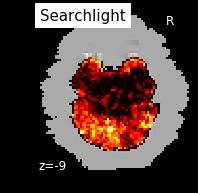

In [194]:
mean_fmri = nl.image.mean_img(fmri)
searchlight_img = nl.image.new_img_like(mean_fmri, searchlight.scores_)

plot_img(searchlight_img, bg_img=mean_fmri,
         title="Searchlight", display_mode="z", cut_coords=[-9],
         vmin=.42, cmap='hot', threshold=.2, black_bg=True)

In [112]:
searchlight.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
 'estimator': 'svc',
 'mask_img': <nibabel.nifti1.Nifti1Image at 0x115213358>,
 'n_jobs': 4,
 'process_mask_img': None,
 'radius': 5.6,
 'scoring': None,
 'verbose': 1}

In [195]:
searchlight_img.to_filename('searchlightResults.nii.gz')

In [121]:
a = mask_img.get_data()
np.sum(a==1)

25182

In [127]:
nl.__path__

['/usr/local/lib/python3.6/site-packages/nilearn']

In [280]:
a = (1,2,3)
','.join(str(x) for x in a)

'1,2,3'

In [281]:
a = ['n', 'n', 'g', 't']


In [ ]:
a = a